##**Assignment 2 - Deep learning for computer vision**

## Objective : Deep learning for computer vision convents can be used successfully to classify images. It is used to help teach computers to “see” and to use visual information to perform visual tasks that humans can.Specifically, consider the Cats & Dogs example. There are two approaches to classifying Cats & Dogs using convnets: Training a network from scratch, versus using a pretrained convnet. While small datasets can lead to overfitting, thus making training a network for prediction more difficult, you also saw several techniques to reduce overfitting, and these include data augmentation and regularization. In this assignment, we will examine the relationship between training samples and the choice of training your model from scratch, versus using a pretrained convnet.

## Date Source : The data set has been imported from Kaggle which contains Training and Test sets with 25000 & 12500 images of cats & dogs which are equal. But, we are going to use only 2000 to build the model.



### Downloading the data from Kaggle

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"npillana","key":"19e4599873232020b8f4ce1504f5f254"}'}

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c dogs-vs-cats

100% 812M/812M [00:06<00:00, 148MB/s]
100% 812M/812M [00:06<00:00, 128MB/s]


In [4]:
!unzip -qq dogs-vs-cats.zip

In [5]:
!unzip -qq train.zip


In [6]:
!unzip -qq test1.zip

**Q1. Consider the Cats & Dogs example. Start initially with a training sample of 1000, a validation sample of 500, and a test sample of 500 (like in the text). Use any technique to reduce overfitting and improve performance in developing a network that you train from scratch. What performance did you achieve?**

#### Test Accuracy - 73.5%

#### Training Accuraccy - 99.3%

#### Validation Accuracy - 74.20%

**Copying images to training, validation, and test directories**

In [7]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)
#Creating training, Test and validation sets.
#Training has 1000 samples, test has 500 samples and validation has 500 samples.
make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2000)

##Data Preprocessing
####First lets Convert the data into Preprocessed floating point tensors before being fed into the model.
####Since the data is in the JPEG file format. We need to follow below  steps of  preprocess:
#### Read the pictures
#### Convert JPEG content into RGB grid of pixels.
#### Convert RGB grid of pixels into floating point tensors.
#### Resize them and Convert them into batches.


**Using image_dataset_from_directory to read images**

In [8]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


Create a datset instance from NumPy array of random numbers of 1000 samples and each sample of vector size is 16.

In [9]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [10]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


Batching the data into batches of size 32.

In [11]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [12]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


**Displaying the shapes of the data and labels yielded by the `Dataset`**

In [13]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


##Building the model

**Instantiating a small convnet for dogs vs. cats classification**


In [14]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

**Configuring the model for training**

In [15]:
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

**Fitting the model using a `Dataset`**

In [21]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 9s 127ms/step - loss: 0.0422 - accuracy: 0.9865 - val_loss: 1.2599 - val_accuracy: 0.7580
Epoch 2/30
63/63 [==============================] - 7s 112ms/step - loss: 0.0530 - accuracy: 0.9835 - val_loss: 1.1914 - val_accuracy: 0.7450
Epoch 3/30
63/63 [==============================] - 7s 109ms/step - loss: 0.0201 - accuracy: 0.9935 - val_loss: 1.5122 - val_accuracy: 0.7360
Epoch 4/30
63/63 [==============================] - 7s 110ms/step - loss: 0.0223 - accuracy: 0.9935 - val_loss: 1.5974 - val_accuracy: 0.7410
Epoch 5/30
63/63 [==============================] - 7s 110ms/step - loss: 0.0281 - accuracy: 0.9905 - val_loss: 1.4385 - val_accuracy: 0.7200
Epoch 6/30
63/63 [==============================] - 7s 111ms/step - loss: 0.0541 - accuracy: 0.9825 - val_loss: 1.3436 - val_accuracy: 0.7350
Epoch 7/30
63/63 [==============================] - 7s 111ms/step - loss: 0.0344 - accuracy: 0.9885 - val_loss: 1.3745 - val_accuracy: 0.7440
Epoch 

**Displaying curves of loss and accuracy during training**

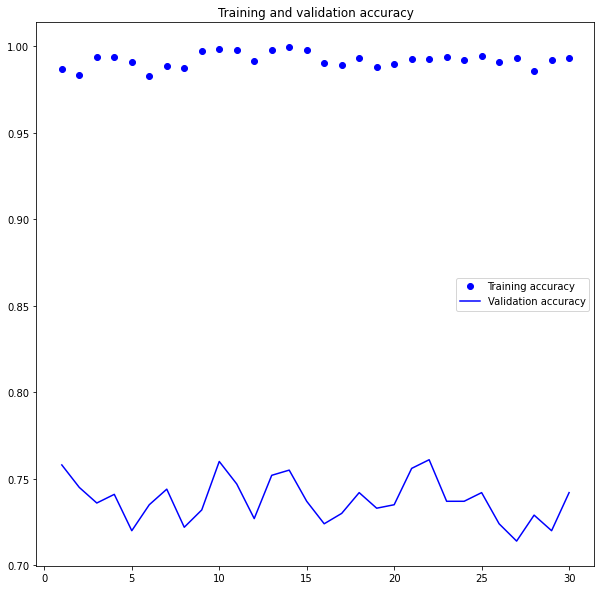

<Figure size 432x288 with 0 Axes>

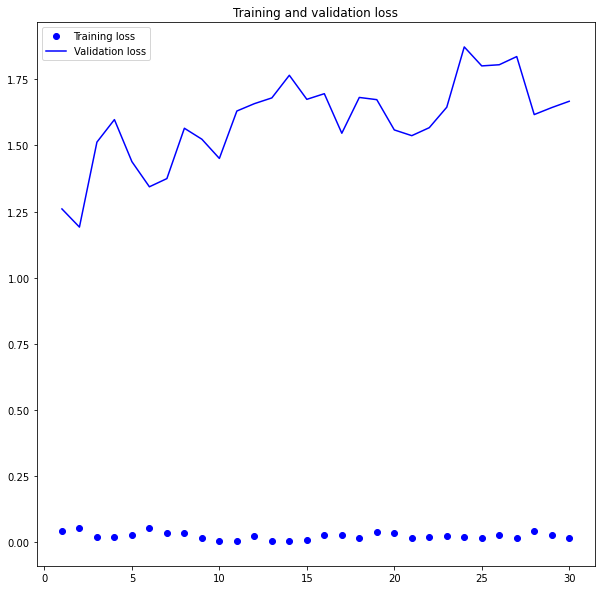

In [22]:

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.figure(figsize=(10, 10))
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**Evaluating the model on the test set**

In [23]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 51ms/step - loss: 1.2511 - accuracy: 0.7350
Test accuracy: 0.735


**Q2.  Increase your training sample size. You may pick any amount. Keep the validation and test samples the same as above. Optimize your network (again training from scratch). What performance did you achieve?**

#### Test Accuracy - 74.3%

#### Training Accuraccy - 78.4%

#### Validation Accuracy - 76.30% 

**Define a data augmentation stage to add to an image model**

In [24]:
import os, shutil, pathlib

shutil.rmtree("./cats_vs_dogs_small_Q2", ignore_errors=True)

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_Q2")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)
#Creating training, Test and validation sets.
#Training has 1000 samples, test has 500 samples and validation has 500 samples.
make_subset("train", start_index=0, end_index=1500)
make_subset("validation", start_index=1500, end_index=2000)
make_subset("test", start_index=2000, end_index=2500)

In [25]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

**Displaying some randomly augmented training images**

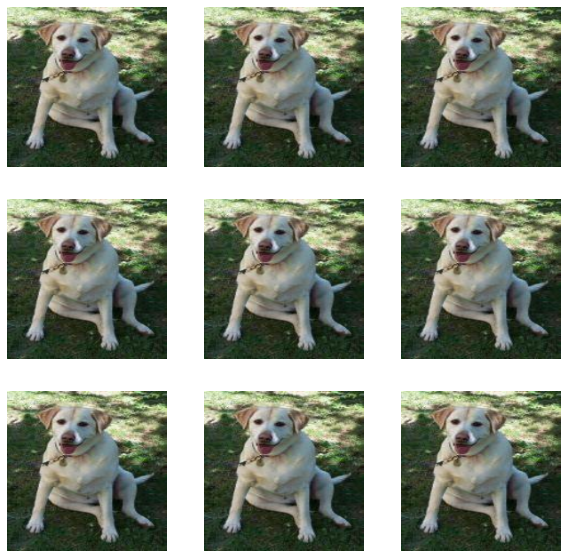

In [26]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

**Defining a new convnet that includes image augmentation and dropout**

In [27]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

**Training the regularized convnet**

In [28]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 12s 155ms/step - loss: 0.6969 - accuracy: 0.4970 - val_loss: 0.6929 - val_accuracy: 0.5000
Epoch 2/30
63/63 [==============================] - 8s 119ms/step - loss: 0.6953 - accuracy: 0.5070 - val_loss: 0.6927 - val_accuracy: 0.5000
Epoch 3/30
63/63 [==============================] - 8s 121ms/step - loss: 0.6932 - accuracy: 0.5110 - val_loss: 0.6916 - val_accuracy: 0.5240
Epoch 4/30
63/63 [==============================] - 8s 121ms/step - loss: 0.6875 - accuracy: 0.5345 - val_loss: 0.6697 - val_accuracy: 0.5550
Epoch 5/30
63/63 [==============================] - 8s 118ms/step - loss: 0.6848 - accuracy: 0.5400 - val_loss: 0.6694 - val_accuracy: 0.5470
Epoch 6/30
63/63 [==============================] - 8s 116ms/step - loss: 0.6646 - accuracy: 0.5645 - val_loss: 0.6725 - val_accuracy: 0.5910
Epoch 7/30
63/63 [==============================] - 8s 124ms/step - loss: 0.6651 - accuracy: 0.5855 - val_loss: 0.6726 - val_accuracy: 0.5560
Epoch

**Evaluating the model on the test set**

In [29]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 51ms/step - loss: 0.5432 - accuracy: 0.7430
Test accuracy: 0.743


**Q3. Now change your training sample so that you achieve better performance than those from Steps 1 and 2. This sample size may be larger, or smaller than those in the previous steps. The objective is to find the ideal training sample size to get best prediction results.**




#### Test Accuracy - 76.1%

#### Training Accuraccy - 85.1%

#### Validation Accuracy - 78.30%


### Here we will increase the training sample to 2000, keeping the Validation and test sets the same as 500 samples.

In [30]:
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_Q3")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)
#Creating training, Test and validation sets.
#Training has 1000 samples, test has 500 samples and validation has 500 samples.
make_subset("train", start_index=0, end_index=2000)
make_subset("validation", start_index=2000, end_index=2500)
make_subset("test", start_index=2500, end_index=3000)

**Defining a new convnet with increased training samples,image augmentation and dropout**

In [31]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [35]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation1.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=35,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/35
63/63 [==============================] - 9s 132ms/step - loss: 0.5544 - accuracy: 0.7255 - val_loss: 0.6111 - val_accuracy: 0.6730
Epoch 2/35
63/63 [==============================] - 8s 121ms/step - loss: 0.5311 - accuracy: 0.7330 - val_loss: 0.5637 - val_accuracy: 0.7070
Epoch 3/35
63/63 [==============================] - 8s 117ms/step - loss: 0.5403 - accuracy: 0.7350 - val_loss: 0.5827 - val_accuracy: 0.6880
Epoch 4/35
63/63 [==============================] - 8s 122ms/step - loss: 0.5245 - accuracy: 0.7440 - val_loss: 0.5594 - val_accuracy: 0.7190
Epoch 5/35
63/63 [==============================] - 8s 120ms/step - loss: 0.5166 - accuracy: 0.7465 - val_loss: 0.5528 - val_accuracy: 0.7140
Epoch 6/35
63/63 [==============================] - 8s 120ms/step - loss: 0.5096 - accuracy: 0.7460 - val_loss: 0.5449 - val_accuracy: 0.7320
Epoch 7/35
63/63 [==============================] - 8s 121ms/step - loss: 0.5031 - accuracy: 0.7595 - val_loss: 0.5215 - val_accuracy: 0.7390
Epoch 

In [36]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation1.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 50ms/step - loss: 0.5052 - accuracy: 0.7610
Test accuracy: 0.761


# Overall Summary for above three questions:
---



### Initially we started by training a small convnet on 1,000 training samples, without any optimization to set a baseline which got us a classification accuracy of 73.5%. The main issue that was identified was overfitting. 

###Then we introduced data augmentation and other optimization techniques like earlystopping(which determines the optimal number of epochs), Regularization and Dropout. By using data augmentation, we improved the model to reach an accuracy of 74.3%.

###Then we tried to find the optimal training sample to increase classification accuracy and we observed by the manipulating of training sample and by using other optimization techniques the best way to prevent overfitting are as follows:
### 1. **Getting more training samples** 
### 2. **Reducing the capacity of the network** - It is observed that reducing the size of the model which is essentially the  number of layers  and the number of units in layers, considerably prevents overfitting
### 3. **Adding weight regularization** - Putting constraint on the complexity of a network by forcing the weights  to take only small values, which helps in regularizing the distribution of the weight values which in turns helps in preventing or minimizing overfitting.
### 4. **Adding dropout** - Zeroing out a number of output features of the layer during training, helps in minimizing overfitting as well. 

---




#Q4. Repeat Steps 1-3, but now using a pretrained network. The sample sizes you use in Steps 2 and 3 for the pretrained network may be the same or different from those using the network where you trained from scratch. Again, use any and all optimization techniques to get best performance.

#### A highly effective approach to apply deep learning on small image datasets is to use a pretrained model. A pretrained model is a model that was previously trained on a large dataset, typically on a large-scale image-classification task.

#### In this case, we will use a large convnet trained on the ImageNet dataset (1.4 million labeled images and 1,000 different classes). We will use VGG16 architecture, however, there are multiple architectures available namely VGG, ResNet, Inception, Xception, and so on.



### Feature extraction with a pretrained model

#### Feature extraction means using the representations learned by a previously trained model (ImageNet, in our case) to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch.

**Instantiating the VGG16 convolutional base**

In [37]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58900480/58889256 [==============================] - 0s 0us/step


In [38]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

### Feature extraction without data augmentation using a pretrained model

**Extracting the VGG16 features and corresponding labels**

In [39]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

In [40]:
train_features.shape

(2000, 5, 5, 512)

**Defining and training the densely connected classifier**

In [41]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=25,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/25
63/63 [==============================] - 2s 14ms/step - loss: 13.0898 - accuracy: 0.9290 - val_loss: 3.5451 - val_accuracy: 0.9730
Epoch 2/25
63/63 [==============================] - 1s 10ms/step - loss: 4.5696 - accuracy: 0.9695 - val_loss: 5.1553 - val_accuracy: 0.9650
Epoch 3/25
63/63 [==============================] - 1s 11ms/step - loss: 1.8141 - accuracy: 0.9880 - val_loss: 4.4878 - val_accuracy: 0.9750
Epoch 4/25
63/63 [==============================] - 1s 11ms/step - loss: 1.9143 - accuracy: 0.9885 - val_loss: 5.2317 - val_accuracy: 0.9760
Epoch 5/25
63/63 [==============================] - 1s 11ms/step - loss: 1.4776 - accuracy: 0.9870 - val_loss: 4.6075 - val_accuracy: 0.9760
Epoch 6/25
63/63 [==============================] - 1s 11ms/step - loss: 1.1422 - accuracy: 0.9900 - val_loss: 5.9955 - val_accuracy: 0.9700
Epoch 7/25
63/63 [==============================] - 1s 10ms/step - loss: 0.4514 - accuracy: 0.9965 - val_loss: 5.1019 - val_accuracy: 0.9750
Epoch 8/25
6

**Plotting the results**

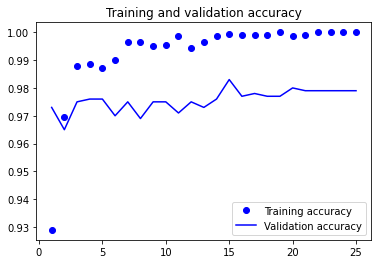

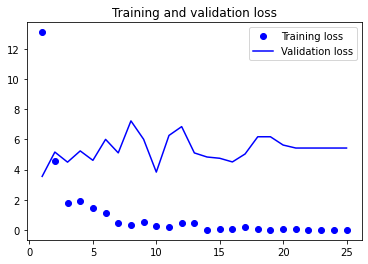

In [42]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### Feature extraction with data augmentation using a pretrained model

**Instantiating and freezing the VGG16 convolutional base**

In [43]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

**Printing the list of trainable weights before and after freezing**

In [44]:
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [45]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


**Adding a data augmentation stage and a classifier to the convolutional base**

In [46]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [47]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 25s 351ms/step - loss: 15.5778 - accuracy: 0.8960 - val_loss: 3.0534 - val_accuracy: 0.9760
Epoch 2/30
63/63 [==============================] - 22s 344ms/step - loss: 8.4205 - accuracy: 0.9360 - val_loss: 3.8696 - val_accuracy: 0.9720
Epoch 3/30
63/63 [==============================] - 22s 344ms/step - loss: 5.6019 - accuracy: 0.9540 - val_loss: 4.0089 - val_accuracy: 0.9770
Epoch 4/30
63/63 [==============================] - 22s 343ms/step - loss: 5.6236 - accuracy: 0.9595 - val_loss: 3.6372 - val_accuracy: 0.9790
Epoch 5/30
63/63 [==============================] - 22s 343ms/step - loss: 4.5770 - accuracy: 0.9675 - val_loss: 4.0001 - val_accuracy: 0.9730
Epoch 6/30
63/63 [==============================] - 22s 344ms/step - loss: 4.2715 - accuracy: 0.9680 - val_loss: 3.1907 - val_accuracy: 0.9790
Epoch 7/30
63/63 [==============================] - 22s 349ms/step - loss: 2.6289 - accuracy: 0.9700 - val_loss: 2.8241 - val_accuracy: 0.982

**Evaluating the model on the test set**

In [48]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 8s 218ms/step - loss: 2.6642 - accuracy: 0.9790
Test accuracy: 0.979


### A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. You either use the pretrained model as is or use transfer learning to customize this model to a given task.

### The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.

### A pretrained VGG16 model with Fine-tuning is a way to customize a pre trained model:

#### Unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model. This allows us to "fine-tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task.

### You will follow the general machine learning workflow.

### Examine and understand the data
### Build an input pipeline, in this case using Keras ImageDataGenerator
### Compose the model
### Load in the pretrained base model (and pretrained weights)
### Stack the classification layers on top
### Train the model
### Evaluate model


In [49]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

**Freezing all layers until the fourth from the last**

In [50]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

**Fine-tuning the model**

In [51]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 26s 383ms/step - loss: 0.5814 - accuracy: 0.9875 - val_loss: 1.4266 - val_accuracy: 0.9840
Epoch 2/30
63/63 [==============================] - 24s 374ms/step - loss: 0.4128 - accuracy: 0.9920 - val_loss: 1.7940 - val_accuracy: 0.9800
Epoch 3/30
63/63 [==============================] - 24s 372ms/step - loss: 0.3807 - accuracy: 0.9905 - val_loss: 1.9125 - val_accuracy: 0.9820
Epoch 4/30
63/63 [==============================] - 24s 373ms/step - loss: 0.5942 - accuracy: 0.9865 - val_loss: 1.8604 - val_accuracy: 0.9800
Epoch 5/30
63/63 [==============================] - 24s 374ms/step - loss: 0.4721 - accuracy: 0.9870 - val_loss: 2.1151 - val_accuracy: 0.9770
Epoch 6/30
63/63 [==============================] - 24s 372ms/step - loss: 0.2160 - accuracy: 0.9920 - val_loss: 1.5881 - val_accuracy: 0.9870
Epoch 7/30
63/63 [==============================] - 24s 375ms/step - loss: 0.2265 - accuracy: 0.9935 - val_loss: 1.7081 - val_accuracy: 0.9830

In [52]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 8s 218ms/step - loss: 1.8811 - accuracy: 0.9750
Test accuracy: 0.975


## Summary

### Using a Pre-trained model without Augmentation

#### We reach a validation accuracy of about 97.80% which is better than what we achieved while training the small model from scratch. This won’t always be the case when you use pretrained features.
#### However, the plots also indicate that we’re overfitting almost from the start—despite using dropout with a fairly large rate. That’s because this technique doesn’t use data augmentation, which is essential for preventing overfitting with small image datasets.

### Using a Pre-trained model without Augmentation

#### A model’s accuracy always depends on the set of samples one evaluates it on! Some sample sets may be more difficult than others, and strong results on one set won’t necessarily fully translate to all other sets. because of this reason, Pretrained model With Augmentation, there was just a minor increase in the accuracy from 97.80% to 98.50%.

### Using Pretrained model with fine tuning
#### Here, we get a test accuracy of 97.5%

### These accuracy results might change within one percentage range of point.